## 通し課題：あるクラウドファンデイングが成功するか(state)を事前に予測するモデルを構築する<BR>（データソース：kaggle / ks-projects-201801）
### 1. 目的変数と説明変数の関係を確認するためのグラフを作成する
### 2.目的変数を説明するのに有効そうな説明変数を見つける

In [34]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix 
# logistic loss; -log P(yt|yp) = -(yt log(yp) + (1 - yt) log(1 - yp))
# accuracy_score(y_true, y_pred)

In [35]:
# 全列を表示させる
print(pd.get_option("display.max_columns"))
pd.set_option('display.max_columns', 100)
print(pd.get_option("display.max_rows"))
pd.set_option('display.max_rows', 200)

100
200


In [36]:
df = pd.read_csv("./ks-projects-201801.csv")

display(df.shape)
display(df.dtypes)
display(df.tail())

# 列の意味
# goal : Goal amount in project currency
# pledged : Pledged amount in the project currency
# usd_pledged: conversion in US dollars of the pledged column (conversion done by kickstarter) 米ドル換算 "not reliable enough"
# usd pledge real: conversion in US dollars of the pledged column (conversion from Fixer.io API) 為替レート変換API使用
# backers : "number of people who have pledged money to the project"

# 仮説　→　結果
# 支援者(backers)が多いほど成功する／集まる金額が多いかもしれない （注意）backer数は事前には分からない。
# 　→成功しているプロジェクトはbackerが多い
# 　→成功しているプロジェクトは一人当たりpledgedが高い
# メインカテゴリー、カテゴリーにより成功し易さが違うかもしれない　→Comics,Dance,Music,Theaterあたりが比較的成功率が高そう
# ローンチからデッドライン迄の期間が成功に影響するかもしれない　→成功しているのは期限設定が短い
# 国によって成功し易さが違うかもしれない　→数としてはUSが圧倒的に多く、GB,CAの英語圏がこれに続く
# 通貨によって成功し易さが違うかもしれない（USDが圧倒的に有利？）　→countryと同様の傾向
# goal金額を低めに設定しているプロジェクトは成功し易いかもしれない　→成功しているのはgoal金額の設定が低い
# プロジェクト名(name)はファンディングに影響する（?) →今回は検討パス

(378661, 15)

ID                    int64
name                 object
category             object
main_category        object
currency             object
deadline             object
goal                float64
launched             object
pledged             float64
state                object
backers               int64
country              object
usd pledged         float64
usd_pledged_real    float64
usd_goal_real       float64
dtype: object

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
378656,999976400,ChknTruk Nationwide Charity Drive 2014 (Canceled),Documentary,Film & Video,USD,2014-10-17,50000.0,2014-09-17 02:35:30,25.0,canceled,1,US,25.0,25.0,50000.0
378657,999977640,The Tribe,Narrative Film,Film & Video,USD,2011-07-19,1500.0,2011-06-22 03:35:14,155.0,failed,5,US,155.0,155.0,1500.0
378658,999986353,Walls of Remedy- New lesbian Romantic Comedy f...,Narrative Film,Film & Video,USD,2010-08-16,15000.0,2010-07-01 19:40:30,20.0,failed,1,US,20.0,20.0,15000.0
378659,999987933,BioDefense Education Kit,Technology,Technology,USD,2016-02-13,15000.0,2016-01-13 18:13:53,200.0,failed,6,US,200.0,200.0,15000.0
378660,999988282,Nou Renmen Ayiti! We Love Haiti!,Performance Art,Art,USD,2011-08-16,2000.0,2011-07-19 09:07:47,524.0,failed,17,US,524.0,524.0,2000.0


In [37]:
## データの理解
# backer一人当たりusd_pledged_real("usd_per_backer")を算出
# print(df["backers"].value_counts()) # 0が55,000でトップ
# sns.distplot(df["backers"],hist=True,bins=10)
if df["backers"].any() ==  0:
    df["usd_per_backer"] = 0
else:
    df["usd_per_backer"] = df["usd_pledged_real"] / df["backers"] 
df["usd_per_backer"] = df["usd_per_backer"].fillna(0) #0を入れるとNaNになってしまうことへの対応
    
# ローンチからデッドライン迄の期間("days")を算出
df["launched"] = pd.to_datetime(df["launched"])
df["launched"] = df["launched"].dt.date # df[列名]で列名を指定すると、その列はpandas.Seriesとして取得される
df["deadline"] = pd.to_datetime(df["deadline"])
df["deadline"] = df["deadline"].dt.date
df["days"] = (df["deadline"] - df["launched"]).dt.days
# df["days"] = (df["deadline"] - df["launched"]) / datetime.timedelta(days=1)

# カテゴリカルデータ"main_category","state","currency"をダミー変数化
df_dummy = pd.get_dummies(df[["main_category","state","currency"]])
df2 = pd.concat([df,df_dummy],axis=1)
df2 = df2.drop(["ID","name","main_category","state","country","currency","pledged","usd pledged","goal","state_canceled","state_failed","state_live","state_suspended","state_undefined"],axis=1)
display(df2.dtypes)
display(df2.tail())

category                       object
deadline                       object
launched                       object
backers                         int64
usd_pledged_real              float64
usd_goal_real                 float64
usd_per_backer                float64
days                            int64
main_category_Art               uint8
main_category_Comics            uint8
main_category_Crafts            uint8
main_category_Dance             uint8
main_category_Design            uint8
main_category_Fashion           uint8
main_category_Film & Video      uint8
main_category_Food              uint8
main_category_Games             uint8
main_category_Journalism        uint8
main_category_Music             uint8
main_category_Photography       uint8
main_category_Publishing        uint8
main_category_Technology        uint8
main_category_Theater           uint8
state_successful                uint8
currency_AUD                    uint8
currency_CAD                    uint8
currency_CHF

,category,deadline,launched,backers,usd_pledged_real,usd_goal_real,usd_per_backer,days,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater,state_successful,currency_AUD,currency_CAD,currency_CHF,currency_DKK,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD
378656,Documentary,2014-10-17,2014-09-17,1,25.0,50000.0,25.000000,30,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
378657,Narrative Film,2011-07-19,2011-06-22,5,155.0,1500.0,31.000000,27,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
378658,Narrative Film,2010-08-16,2010-07-01,1,20.0,15000.0,20.000000,46,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
378659,Technology,2016-02-13,2016-01-13,6,200.0,15000.0,33.333333,31,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
378660,Performance Art,2011-08-16,2011-07-19,17,524.0,2000.0,30.823529,28,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [38]:
## データの理解
display(df.describe())
display(df2.describe())

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real,usd_per_backer,days
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04,inf,34.481095
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06,NaN,65.909173
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02,0.000000e+00,1.000000
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03,1.420000e+01,30.000000
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03,4.084184e+01,30.000000
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04,7.722222e+01,37.000000
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08,inf,16739.000000


,backers,usd_pledged_real,usd_goal_real,usd_per_backer,days,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater,state_successful,currency_AUD,currency_CAD,currency_CHF,currency_DKK,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD
count,378661.000000,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.00000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000
mean,105.617476,9.058924e+03,4.545440e+04,inf,34.481095,0.074349,0.028572,0.023264,0.009951,0.079411,0.060254,0.167921,0.064971,0.093041,0.012557,0.137109,0.028466,0.105303,0.086011,0.02882,0.353762,0.020995,0.039513,0.002028,0.002982,0.045965,0.090139,0.001632,0.000106,0.004627,0.001907,0.003895,0.004722,0.001466,0.780025
std,907.185035,9.097334e+04,1.152950e+06,NaN,65.909173,0.262338,0.166600,0.150740,0.099257,0.270380,0.237958,0.373796,0.246475,0.290490,0.111354,0.343963,0.166300,0.306943,0.280381,0.16730,0.478137,0.143368,0.194812,0.044990,0.054522,0.209409,0.286381,0.040366,0.010277,0.067863,0.043624,0.062291,0.068554,0.038256,0.414230
min,0.000000,0.000000e+00,1.000000e-02,0.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,3.100000e+01,2.000000e+03,1.420000e+01,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,12.000000,6.243300e+02,5.500000e+03,4.084184e+01,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,56.000000,4.050000e+03,1.550000e+04,7.722222e+01,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,219382.000000,2.033899e+07,1.663614e+08,inf,16739.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [39]:
## データの理解
# 欠損値の確認
display(df.isnull().sum())
display(df2.isnull().sum())

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
usd_per_backer         0
days                   0
dtype: int64

category                      0
deadline                      0
launched                      0
backers                       0
usd_pledged_real              0
usd_goal_real                 0
usd_per_backer                0
days                          0
main_category_Art             0
main_category_Comics          0
main_category_Crafts          0
main_category_Dance           0
main_category_Design          0
main_category_Fashion         0
main_category_Film & Video    0
main_category_Food            0
main_category_Games           0
main_category_Journalism      0
main_category_Music           0
main_category_Photography     0
main_category_Publishing      0
main_category_Technology      0
main_category_Theater         0
state_successful              0
currency_AUD                  0
currency_CAD                  0
currency_CHF                  0
currency_DKK                  0
currency_EUR                  0
currency_GBP                  0
currency_HKD                  0
currency

In [40]:
## データの理解
# main_category別内訳
display(df["main_category"].value_counts())
# print(df2.columns)

# category別内訳
# display(df["category"].value_counts())

Film & Video    63585
Music           51918
Publishing      39874
Games           35231
Technology      32569
Design          30070
Art             28153
Food            24602
Fashion         22816
Theater         10913
Comics          10819
Photography     10779
Crafts           8809
Journalism       4755
Dance            3768
Name: main_category, dtype: int64

In [41]:
## データの理解
# country別内訳
display(df["country"].value_counts())

US      292627
GB       33672
CA       14756
AU        7839
DE        4171
N,0"      3797
FR        2939
IT        2878
NL        2868
ES        2276
SE        1757
MX        1752
NZ        1447
DK        1113
IE         811
CH         761
NO         708
HK         618
BE         617
AT         597
SG         555
LU          62
JP          40
Name: country, dtype: int64

In [42]:
## データの理解
# main_categoryで集計
pd.pivot_table(df,index="main_category",columns="state",values="ID",aggfunc="count")
# →Comics,Dance,Music,Theaterあたりが比較的成功率が高そう

state,canceled,failed,live,successful,suspended,undefined
main_category,,,,,,
Art,2222.0,14131.0,194.0,11510.0,96.0,NaN
Comics,842.0,4036.0,76.0,5842.0,23.0,NaN
Crafts,843.0,5703.0,76.0,2115.0,72.0,NaN
Dance,163.0,1235.0,18.0,2338.0,13.0,1.0
Design,4152.0,14814.0,305.0,10550.0,247.0,2.0
Fashion,2650.0,14182.0,250.0,5593.0,138.0,3.0
Film & Video,5755.0,32904.0,332.0,23623.0,117.0,854.0
Food,2211.0,15969.0,184.0,6085.0,153.0,NaN
Games,6202.0,16003.0,287.0,12518.0,220.0,1.0


In [43]:
## データの理解
# main_category,categoryをpivotで集計
pd.pivot_table(df,index=["main_category","category"],columns="state",values="ID",aggfunc="count")

state                             canceled   failed   live  successful  \
main_category category                                                   
Art           Art                    669.0   4101.0   63.0      3385.0   
              Ceramics                27.0    143.0    3.0       132.0   
              Conceptual Art          86.0    564.0    8.0       366.0   
              Digital Art            158.0    800.0   15.0       371.0   
              Illustration           235.0   1264.0   41.0      1626.0   
              Installations           35.0    203.0    7.0       233.0   
              Mixed Media            221.0   1568.0   19.0       945.0   
              Painting               228.0   1886.0   19.0      1149.0   
              Performance Art        167.0   1040.0    4.0       934.0   
              Public Art             210.0   1307.0    7.0      1543.0   
              Sculpture              146.0    959.0    4.0       698.0   
              Textiles                24.0    173.0    2.0        77.0   
              Video Art               16.0    123.0    2.0        51.0   
Comics        Anthologies             16.0     83.0    3.0       303.0   
              Comic Books            214.0    879.0   33.0      1614.0   
              Comics                 392.0   2075.0   15.0      2506.0   
              Events                  16.0     90.0    2.0        50.0   
              Graphic Novels         160.0    668.0   19.0      1011.0   
              Webcomics               44.0    241.0    4.0       358.0   
Crafts        Candles                 49.0    323.0    2.0        55.0   
              Crafts                 451.0   2990.0   33.0      1162.0   
              Crochet                 11.0    116.0    NaN        35.0   
              DIY                    109.0    834.0   20.0       183.0   
              Embroidery              12.0     81.0    1.0        19.0   
              Glass                   14.0     84.0    NaN        38.0   
              Knitting                16.0     79.0    NaN        85.0   
              Letterpress              1.0     11.0    NaN        25.0   
              Pottery                  8.0     44.0    4.0        44.0   
              Printing                41.0    146.0    2.0        49.0   
              Quilts                   6.0     56.0    NaN        19.0   
              Stationery              24.0    113.0    2.0        77.0   
              Taxidermy                1.0      5.0    NaN         5.0   
              Weaving                  8.0     55.0    1.0        27.0   
              Woodworking             92.0    766.0   11.0       292.0   
Dance         Dance                   96.0    676.0    5.0      1542.0   
              Performances            39.0    337.0    7.0       624.0   
              Residencies              1.0     18.0    NaN        50.0   
              Spaces                  17.0    106.0    2.0        72.0   
              Workshops               10.0     98.0    4.0        50.0   
Design        Architecture            96.0    463.0   11.0       179.0   
              Civic Design            15.0    162.0    5.0       104.0   
              Design                 575.0   2134.0   38.0      1413.0   
              Graphic Design         200.0   1040.0    8.0       750.0   
              Interactive Design      51.0    263.0    4.0        79.0   
              Product Design        3207.0  10718.0  237.0      7962.0   
              Typography               8.0     34.0    2.0        63.0   
Fashion       Accessories            340.0   1667.0   53.0      1073.0   
              Apparel                864.0   4752.0  109.0      1414.0   
              Childrenswear           61.0    323.0    2.0        95.0   
              Couture                 41.0    185.0    5.0        42.0   
              Fashion                945.0   5341.0   40.0      2188.0   
              Footwear               122.0    486.0    9.0       298.0   
    

In [44]:
## データの理解
# countryをpivotで集計
pd.pivot_table(df,index=["country"],columns="state",values="ID",aggfunc="count")
# →数としてはUSが圧倒的に多く、GB,CAの英語圏がこれに続く

state,canceled,failed,live,successful,suspended,undefined
country,,,,,,
AT,91.0,378.0,15.0,107.0,6.0,NaN
AU,1065.0,4606.0,70.0,2010.0,88.0,NaN
BE,74.0,371.0,12.0,152.0,8.0,NaN
CA,2138.0,8236.0,132.0,4134.0,116.0,NaN
CH,84.0,465.0,14.0,187.0,11.0,NaN
DE,621.0,2499.0,75.0,937.0,39.0,NaN
DK,157.0,566.0,16.0,360.0,14.0,NaN
ES,331.0,1381.0,52.0,492.0,20.0,NaN
FR,353.0,1612.0,52.0,908.0,14.0,NaN


In [45]:
## データの理解
# currencyをpivotで集計
pd.pivot_table(df,index=["currency"],columns="state",values="ID",aggfunc="count")
# →countryと同様の傾向

state,canceled,failed,live,successful,suspended,undefined
currency,,,,,,
AUD,1067.0,4610.0,70.0,2011.0,89.0,103.0
CAD,2138.0,8238.0,132.0,4137.0,116.0,201.0
CHF,84.0,465.0,14.0,187.0,11.0,7.0
DKK,157.0,567.0,16.0,362.0,14.0,13.0
EUR,2389.0,10496.0,329.0,3882.0,147.0,162.0
GBP,3763.0,17395.0,279.0,12081.0,178.0,436.0
HKD,87.0,261.0,35.0,216.0,19.0,NaN
JPY,8.0,16.0,9.0,7.0,NaN,NaN
MXN,221.0,1015.0,107.0,396.0,13.0,NaN


(0, 100)

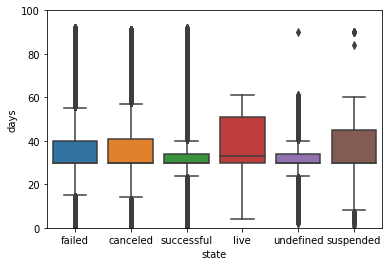

In [46]:
## データの理解
# 外れ値の確認
f = sns.boxplot(x="state",y="days",data=df)
# f.set_yscale("log")
f.set_ylim(0,100)

# →成功しているのは期限設定が短い

(0, 50000)

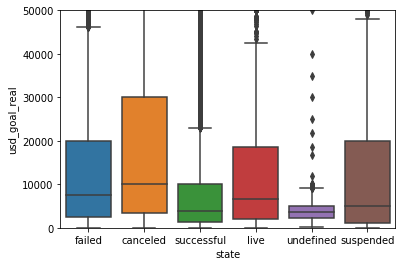

In [47]:
## データの理解
# 外れ値の確認
i = sns.boxplot(x="state",y="usd_goal_real",data=df)
# i.set_yscale("log")
i.set_ylim(0,50000)

# →成功しているのはgoal金額の設定が低い

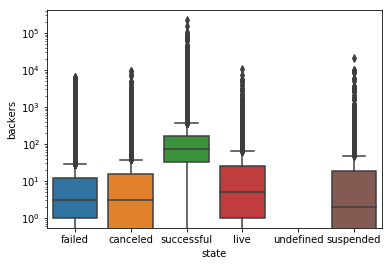

In [48]:
g = sns.boxplot(x="state",y="backers",data=df)
g.set_yscale("log")
# →成功しているのは当然ながらbackerが多い

(0, 500)

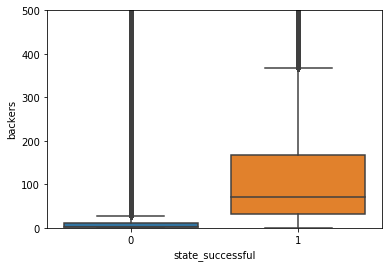

In [49]:
## データの理解
h = sns.boxplot(x = df2.state_successful,y = df2.backers)
h.set_ylim(0,500)

C:\Users\bb101\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1221: RuntimeWarning: invalid value encountered in double_scalars
  stats['iqr'] = q3 - q1
C:\Users\bb101\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1246: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = np.compress(x <= hival, x)
C:\Users\bb101\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1253: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = np.compress(x >= loval, x)


(0, 200)

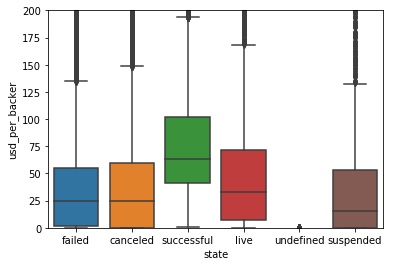

In [50]:
k = sns.boxplot(x="state",y="usd_per_backer",data=df)
k.set_ylim(0,200)
# →成功しているのは一人当たりpledgedが多い

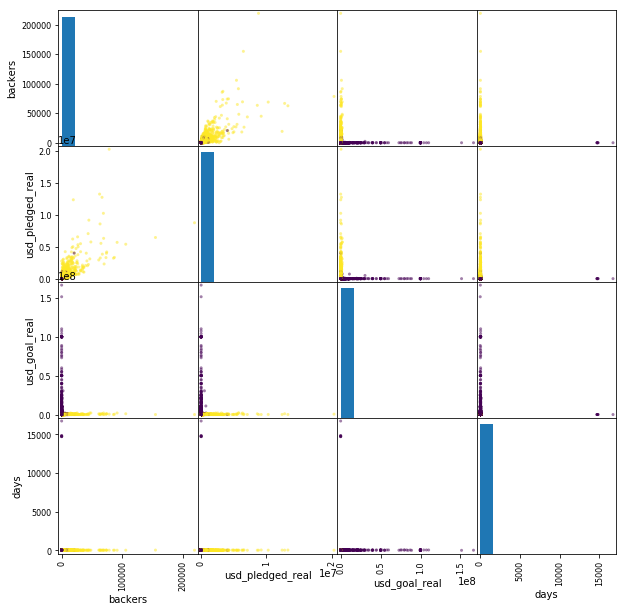

In [20]:
## データの理解
# 散布図行列を書いてみる
pd.plotting.scatter_matrix(df2[["backers","usd_pledged_real","usd_goal_real","days"]],c = df2.state_successful ,figsize = (10,10))
plt.show()
# plt.legend()

In [51]:
## データの理解
# 相関係数を確認
df2[["backers","usd_pledged_real","usd_goal_real","days"]].corr()

,backers,usd_pledged_real,usd_goal_real,days
backers,1.000000,0.752539,0.004517,-0.000792
usd_pledged_real,0.752539,1.000000,0.005596,0.000946
usd_goal_real,0.004517,0.005596,1.000000,0.004184
days,-0.000792,0.000946,0.004184,1.000000


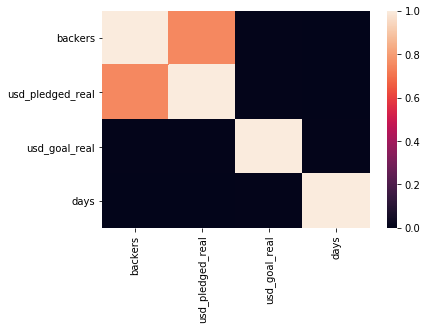

In [52]:
## データの理解
# 相関係数をヒートマップにして可視化
sns.heatmap(df2[["backers","usd_pledged_real","usd_goal_real","days"]].corr())
plt.show()
# →当然ながら"backers"と"usd_pledged_real"の相関は高い

### 3.DAY1で学んだアルゴリズムを利用する
-  回帰の場合は線形回帰、分類の場合はロジスティック回帰
-  質的変数が扱えないアルゴリズムを使う場合は、ダミー変数に置き換える

In [53]:
y = df2["state_successful"].values
X = df2[["usd_pledged_real","usd_goal_real","days","main_category_Art","main_category_Comics","main_category_Crafts","main_category_Dance","main_category_Design","main_category_Fashion","main_category_Film & Video","main_category_Food","main_category_Games","main_category_Journalism","main_category_Music","main_category_Photography","main_category_Publishing","main_category_Technology","main_category_Theater","currency_AUD","currency_CAD","currency_CHF","currency_DKK","currency_EUR","currency_GBP","currency_HKD","currency_JPY","currency_MXN","currency_NOK","currency_NZD","currency_SEK","currency_SGD","currency_USD"]].values
# category,currencyは一先ず除外
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(X, y)
# display(df2["state_successful"].value_counts())

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=10000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='none',
       power_t=0.5, random_state=1234, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [54]:
display(y.shape)
display(X.shape)

(378661,)

(378661, 32)

In [55]:
# ラベルを予測
y_est = clf.predict(X)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_est)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y, y_est)))

対数尤度 = -0.289
正答率 = 99.163%


### 4.予測精度または識別精度を確認する
-  回帰問題の場合は、MSE、RMSE、MAEを求める
-  分類問題の場合は、混同行列を作成し、Accuracy、Recall、Precisionを求める

In [56]:
#予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y, y_est), 
                        index=['正解 = 成功', '正解 = 失敗'], 
                        columns=['予測 = 成功', '予測 = 失敗'])
conf_mat

,予測 = 成功,予測 = 失敗
正解 = 成功,241538,3167
正解 = 失敗,2,133954


### 5.できたところまでをNotebookでまとめ、GithubまたはGistで公開する